In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session (bind=engine)

In [11]:
inspector = inspect(engine)


In [12]:
inspector.get_table_names()

['measurement', 'station']

In [13]:
columns = inspector.get_columns('measurement')
for column in columns:
    print (column['name'])

id
station
date
prcp
tobs


In [14]:
columns = inspector.get_columns('station')
for column in columns:
    print (column['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

In [46]:
max_date = session.query(func.max(Measurement.date)).all()[0][0]
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query_date = max_date - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()
results


[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [73]:
precipitation_df = pd.DataFrame(results)
precipitation_df.dropna(inplace=True)

precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])


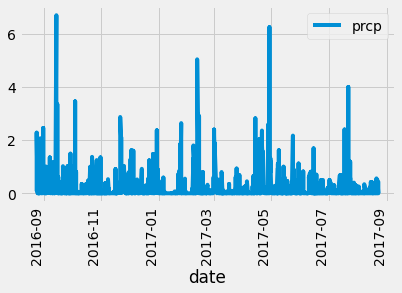

In [74]:
# Save the query results as a Pandas DataFrame and set the index to the date column
#precipitation_df = pd.DataFrame(results)
#precipitation_df.dropna(inplace=True)

precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
#precipitaion_df = precipitation_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
#precipitation_df = precipitation_df.sort_values('date', ascending = False).reset_index(drop=True)

precipitation_df.plot(rot=90)

In [57]:
precipitation_df = precipitation_df.sort_values('date', ascending = False).reset_index(drop=True)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()[0][0]

9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(func.count(Measurement.station), Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = 'USC00519281'
session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()


[(85.0, 54.0, 71.66378066378067)]

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == station_id).\
    filter(Measurement.date >= query_date).all()
temp[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

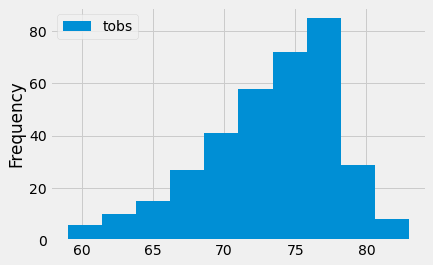

In [51]:
temp_df = pd.DataFrame(temp)
temp_df.set_index('date')
temp_df.plot(kind='hist')

## Bonus Challenge Assignment

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
